In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df_X = pd.read_csv('X_gexp.csv')
df_Y = pd.read_csv('y_gexp.csv')
df_X.drop(columns=["Unnamed: 0"],inplace=True)
df_Y.drop(columns=["Unnamed: 0"],inplace=True)
df_X.head()

,FSTL1,ELMO2,CREB3L1,PNMA1,MMP2,SMARCD3,PKNOX2,RALYL,ZHX3,APBB2,...,ST18,PSMB9,ProSAPiP1,HCLS1,MMP9,KIAA0802,DHRS2,SGEF,PIK3IP1,CTSC
0,2.275179,1.873549,1.772059,2.144198,2.269443,1.742389,1.797055,1.677848,1.801352,1.786488,...,1.669895,2.346811,2.004333,2.213310,2.407606,2.083333,2.098461,1.680092,1.953595,2.429578
1,2.569520,2.085888,1.961846,2.315705,2.505400,2.226593,1.798769,1.671170,2.000942,2.089285,...,1.516024,2.339930,2.045828,2.285701,2.633632,1.938474,1.614437,1.760419,2.010156,2.431814
2,2.471492,2.030865,1.845808,2.072279,2.346815,1.783762,1.707150,1.599492,1.823480,1.778307,...,1.527561,2.302006,2.059862,2.130193,2.349831,1.815239,1.857933,1.675823,2.011970,2.434026
3,2.464403,2.094165,1.762169,2.374129,2.213562,2.209426,1.925440,1.936043,2.003743,2.024847,...,1.611626,2.208924,2.050555,2.213955,1.982603,2.125508,1.631955,1.881003,1.886280,2.450704
4,2.365457,2.188070,1.763206,2.340024,2.219210,2.308335,1.801007,1.756726,2.115714,2.086733,...,1.570489,2.187420,2.265522,2.192262,1.796491,1.979615,1.637215,2.182186,1.897957,2.140727


In [5]:
df_X.shape

(302, 5000)

In [6]:
df_X.isna().sum()

FSTL1       0
ELMO2       0
CREB3L1     0
PNMA1       0
MMP2        0
           ..
KIAA0802    0
DHRS2       0
SGEF        0
PIK3IP1     0
CTSC        0
Length: 5000, dtype: int64

In [7]:
df_Y.head()

,x
0,0
1,1
2,0
3,0
4,0


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_X)

In [9]:
variance = VarianceThreshold(threshold=1.0) 
X_filtered = variance.fit_transform(X_scaled)
selected_features_variance = df_X.columns[variance.get_support()]
print("Selected features:", selected_features_variance)

Selected features: Index(['FSTL1', 'PNMA1', 'BBOX1', 'EDN1', 'CRNKL1', 'BANK1', 'NR4A2',
       'MAP1LC3C', 'SLCO2B1', 'ANKRD6',
       ...
       'GAB1', 'CP', 'G6PC3', 'NDUFS7', 'S100A13', 'RPS6KA3', 'DACT1', 'EAF2',
       'HCLS1', 'PIK3IP1'],
      dtype='object', length=981)


In [10]:
pca = PCA(n_components=0.99, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Number of components kept:", pca.n_components_)

Explained variance ratio: [0.20340018 0.11477919 0.07821268 0.03545906 0.0308693  0.02112771
 0.02090315 0.01875553 0.01597494 0.01560346 0.01439048 0.01384711
 0.0110561  0.00981724 0.00974779 0.00868764 0.00824579 0.00797324
 0.00761317 0.00741741 0.00706661 0.0066442  0.00651056 0.00623483
 0.00584102 0.00566617 0.00553621 0.00515573 0.00507862 0.00483169
 0.00461656 0.00459624 0.00444038 0.00430193 0.00400767 0.00393192
 0.00386651 0.00384336 0.00365156 0.00357042 0.00350832 0.00345822
 0.0033634  0.00324607 0.00308716 0.00304122 0.00294507 0.00287947
 0.00283553 0.0027914  0.00275843 0.00271642 0.00266701 0.00261579
 0.00255127 0.00254202 0.00246241 0.00241631 0.00237861 0.00229144
 0.00226327 0.00225421 0.00219408 0.00216979 0.00215688 0.00212784
 0.00208422 0.00201147 0.00197534 0.00195987 0.00193366 0.00189545
 0.00186948 0.00184815 0.00179394 0.00177606 0.00175101 0.00171196
 0.00168939 0.00167262 0.00164485 0.00163102 0.00162419 0.00157123
 0.00155399 0.00153307 0.00151156 0.

## Clustering-Based Feature Selection
This section evaluates each feature based on its ability to form clusters using the silhouette score.

In [12]:
def cluster_feature_score(X, n_clusters=3):
    scores = {}
    for i in range(X.shape[1]):
        feature = X[:, i].reshape(-1, 1)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(feature)
        labels = kmeans.labels_
        try:
            score = silhouette_score(feature, labels)
        except ValueError:
            score = -1  # Handle cases where clustering fails
        scores[i] = score
    return scores

In [13]:

# Apply to scaled dataset
feature_scores = cluster_feature_score(X_scaled, n_clusters=3)

# Sort and select top N features
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
top_feature_indices = [idx for idx, score in sorted_features[:20]]  # Top 20 features

# New feature matrix
X_selected = X_scaled[:, top_feature_indices]


c:\Users\marta\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marta\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\marta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\marta\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, wh

In [15]:
# Map indices to actual feature names
top_feature_names = df_X.columns[top_feature_indices]

print("Top 20 Features Based on Clustering:")
for i, name in enumerate(top_feature_names):
    print(f"{i+1}. {name}")


Top 20 Features Based on Clustering:
1. KRT6A
2. CLCA2
3. SERPINB5
4. VTCN1
5. CEACAM6
6. SFTPB
7. ADH1B
8. SFTPC
9. KRT13
10. UPK1B
11. SCGB1A1
12. EPYC
13. KRT19
14. AGR2
15. GPX2
16. SCEL
17. GSTA1
18. TMC5
19. SCGB2A1
20. RAB25


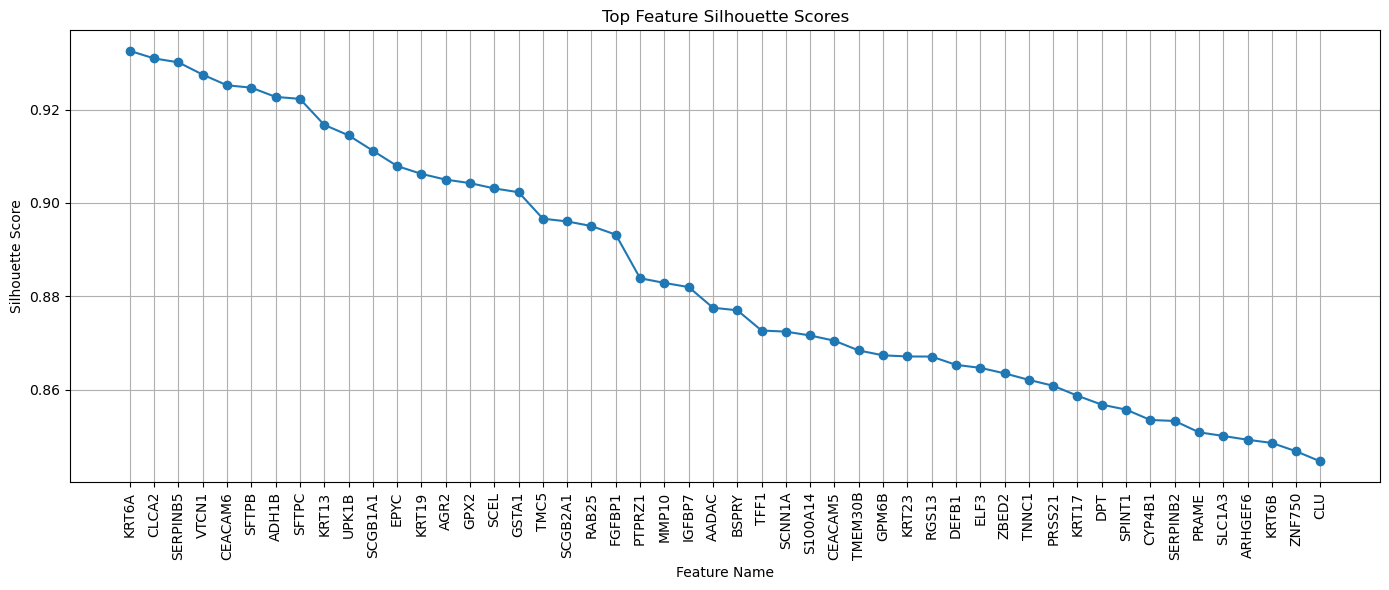

In [16]:
# Plot top 50 features with names
top_50 = sorted_features[:50]
feature_names = [df_X.columns[idx] for idx, _ in top_50]
scores = [score for _, score in top_50]

plt.figure(figsize=(14, 6))
plt.plot(feature_names, scores, marker='o')
plt.xticks(rotation=90)
plt.title("Top Feature Silhouette Scores")
plt.xlabel("Feature Name")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.grid(True)
plt.show()
